In [68]:
import scanpy as sc
import pandas as pd
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import requests
import sklearn.decomposition #import TruncatedSVD
import scipy 
import sparse, io
import scvi
from cellbender.remove_background.downstream import anndata_from_h5
#Load in the raw first spleen dataset
adata_pl_1_raw=sc.read_10x_h5("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/matrix_filtered_clear/run2/output_filtered.h5")

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [69]:
#Load in the raw second spleen dataset
from cellbender.remove_background.downstream import anndata_from_h5
adata_pl_2_raw= sc.read_10x_h5('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/matrix_filtered_clear/second_spleen/output_filtered.h5')

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [70]:
#Load in the souporcell annotated spleen dataset
souporcell_1=pd.read_table('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nick/Pleuro/outs/20230704_spleen_R1_soup/20230603_24h_soup_res/clusters.tsv')
souporcell_2=pd.read_table('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nick/Pleuro/outs/20230704_spleen_R2_soup/20230603_24h_soup_res/clusters.tsv')
#Replace the variables load in the triannotate file
mapper=pd.read_table("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/aPlwal.pri.V2.genome.annots.tsv")
mapper_dict = mapper.set_index('#gene_id')['EggNM.Preferred_name'].to_dict()
status_1_mapper=dict(zip(souporcell_1['barcode'],souporcell_1['status']))
assignment_1_mapper=dict(zip(souporcell_1['barcode'],souporcell_1['assignment']))
status_2_mapper=dict(zip(souporcell_2['barcode'],souporcell_2['status']))
assignment_2_mapper=dict(zip(souporcell_2['barcode'],souporcell_2['assignment']))

In [71]:
souporcell_1

,barcode,status,assignment,singlet_posterior,doublet_posterior,log_prob_singleton,log_prob_doublet,cluster0,cluster1,cluster2
0,AAACCCAAGACGCTCC-1,singlet,0,1.000000,0.000000,-301.963147,-376.527277,-301.963147,-583.471541,-693.971984
1,AAACCCAAGATCCTAC-1,singlet,1,1.000000,0.000000,-2112.379393,-3023.262770,-4540.653961,-2112.379393,-5531.126940
2,AAACCCAAGCCGCACT-1,singlet,0,1.000000,0.052198,-108.464387,-111.363483,-108.464387,-140.623852,-155.179660
3,AAACCCAAGCCTCAAT-1,doublet,0/2,1.000000,1.000000,-1372.955960,-1203.210921,-1372.955960,-1771.568065,-1489.529727
4,AAACCCAAGCTTTCTT-1,singlet,0,1.000000,0.019293,-148.872530,-152.801065,-148.872530,-187.814607,-197.468175
...,...,...,...,...,...,...,...,...,...,...
33570,TTTGTTGTCCTTATCA-1,singlet,1,1.000000,0.000000,-473.396573,-685.476398,-1157.135002,-473.396573,-1210.150476
33571,TTTGTTGTCGTGTGAT-1,singlet,0,1.000000,0.024682,-67.755812,-71.432507,-67.755812,-110.078380,-100.316988
33572,TTTGTTGTCTAATTCC-1,singlet,0,0.999999,0.007775,-62.902947,-67.752006,-62.902947,-87.334812,-95.160920
33573,TTTGTTGTCTACGGTA-1,singlet,0,1.000000,0.000000,-1194.160338,-1295.779415,-1194.160338,-1906.001378,-1879.515143


In [72]:
#Add in the souporcell annotation to the first and second spleen dataset
adata_pl_1_raw.obs['status']='NA'
adata_pl_1_raw.obs['assignment']='NA'
adata_pl_1_raw.obs['batch']='1'
adata_pl_2_raw.obs['status']='NA'
adata_pl_2_raw.obs['assignment']='NA'
adata_pl_2_raw.obs['batch']='2'
for i in adata_pl_1_raw.obs.index:
    if i in status_1_mapper.keys():
        adata_pl_1_raw.obs.loc[i,'status']=status_1_mapper[i]
        adata_pl_1_raw.obs.loc[i,'assignment']=assignment_1_mapper[i]
for i in adata_pl_2_raw.obs.index:
    if i in status_2_mapper.keys():
        adata_pl_2_raw.obs.loc[i,'status']=status_2_mapper[i]
        adata_pl_2_raw.obs.loc[i,'assignment']=assignment_2_mapper[i]

In [52]:
adata_pl_1_raw.var_names

Index(['POL3', 'gene26597', 'gene26598', 'SPX2', 'gene26599', 'gene26600',
       'gene26601', 'gene26602', 'gene26603', 'POL',
       ...
       'gene65588', 'gene65589', 'gene65590', 'gene65591', 'gene65592', 'NU5M',
       'COX1', 'COX1', 'NU2M', 'gene65597'],
      dtype='object', name='gene_name', length=65597)

In [137]:
adata_pl_2_raw.obs

,status,assignment,batch
GACCCAGGTAGACGTG-1,singlet,1,2
CACAACAGTATGCTTG-1,singlet,1,2
TCATACTAGAGCCTGA-1,singlet,1,2
CAACAGTGTGGAGGTT-1,singlet,1,2
AGTGCCGAGGGAGGCA-1,singlet,1,2
...,...,...,...
TTTCCTCAGACTTAAG-1,singlet,0,NaN
TTTGATCAGCACCAGA-1,doublet,1/0,NaN
TTTGATCCAAGCGCTC-1,singlet,1,NaN
TTTGGAGCACATATCG-1,doublet,2/0,NaN


In [73]:
#Filter out the cells
adata_pl_1_raw.var_names = [mapper_dict.get(x, x) if mapper_dict.get(x, x) != '.' else x for x in adata_pl_1_raw.var_names]
adata_pl_2_raw.var_names = [mapper_dict.get(x, x) if mapper_dict.get(x, x) != '.' else x for x in adata_pl_2_raw.var_names]
#Preprocess the data
mt_gene_patterns = ['COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'NU1M', 'NU2M', 'NU3M', 'NU4M', 'NU4LM', 'NU5M', 'NU6M', 'CYB']
mt_gene_pattern = '|'.join(mt_gene_patterns)
for adata in [adata_pl_1_raw, adata_pl_2_raw]:
    sc.pp.filter_cells(adata, min_genes=400)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var_names.str.match(mt_gene_pattern)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 10, :]
    adata.var_names_make_unique()

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikvaku/.local/lib/python3.9/site-packages/a

In [7]:
scvi.model.SCVI.setup_anndata(adata_pl_1_raw)
vae = scvi.model.SCVI(adata_pl_1_raw)
vae.train()
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()
df_1 = solo.predict()
df_1['prediction'] = solo.predict(soft=False)

scvi.model.SCVI.setup_anndata(adata_pl_2_raw)
vae = scvi.model.SCVI(adata_pl_2_raw)
vae.train()
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()
df_2 = solo.predict()
df_2['prediction'] = solo.predict(soft=False)

/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nikvaku/PycharmProjects/samap/lib/python3.9/si ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to r

Epoch 400/400: 100%|██████████| 400/400 [1:10:45<00:00, 10.68s/it, v_num=1, train_loss_step=5.89e+3, train_loss_epoch=5.89e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [1:10:45<00:00, 10.61s/it, v_num=1, train_loss_step=5.89e+3, train_loss_epoch=5.89e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nikvaku/PycharmProjects/samap/lib/python3.9/si ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used

Epoch 350/400:  88%|████████▊ | 350/400 [04:32<00:38,  1.28it/s, v_num=1, train_loss_step=0.287, train_loss_epoch=0.296]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.272. Signaling Trainer to stop.


/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nikvaku/PycharmProjects/samap/lib/python3.9/si ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nikvaku/PycharmProjects/samap/lib/python3.9/si ...
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [40:24<00:00,  6.51s/it, v_num=1, train_loss_step=5.79e+3, train_loss_epoch=6.25e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [40:24<00:00,  6.06s/it, v_num=1, train_loss_step=5.79e+3, train_loss_epoch=6.25e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nikvaku/PycharmProjects/samap/lib/python3.9/si ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nikvaku/PycharmProjects/samap/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used

Epoch 291/400:  73%|███████▎  | 291/400 [02:10<00:48,  2.23it/s, v_num=1, train_loss_step=0.453, train_loss_epoch=0.354]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.348. Signaling Trainer to stop.


In [9]:
#Save the scvi predictions
df_1.to_csv('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/scvi_predictions_spleen1.csv')
df_2.to_csv('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/scvi_predictions_spleen2.csv')

In [10]:
adata_pl_1_raw.obs

,status,assignment,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels
CACTAAGTCGGCATAT-1,doublet,0/1,1,13114,13099,156817,2316,1.476881,0,0
CAGCAATGTCCTACGG-1,singlet,2,1,13103,13082,155792,765,0.491039,0,0
AGAGAGCTCGACCCAG-1,singlet,0,1,12166,12153,118372,1673,1.413341,0,0
GTTGTAGGTGTTGAGG-1,singlet,2,1,7274,7269,111308,1040,0.934344,0,0
TGTGATGAGAATTGTG-1,singlet,2,1,11227,11214,104191,961,0.922345,0,0
...,...,...,...,...,...,...,...,...,...,...
TCTTAGTCACAGACGA-1,singlet,1,1,837,837,1055,60,5.687204,0,0
TCGCTCATCTGCGGCA-1,singlet,2,1,1264,1263,1561,5,0.320307,0,0
AACGAAATCGATGCTA-1,singlet,0,1,403,401,639,0,0.000000,0,0
TGTGATGTCGCGTCGA-1,singlet,0,1,615,615,944,150,15.889831,0,0


/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


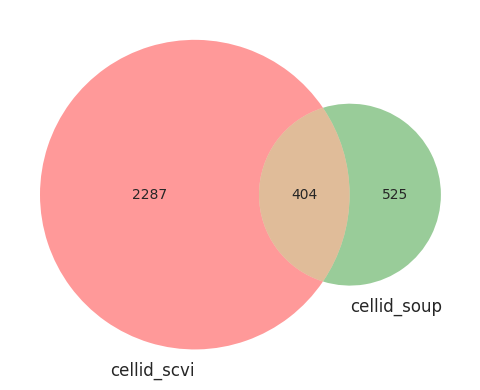

In [74]:
#Remove Doublets from the second spleen dataset
adata_pl_2_raw_dob = adata_pl_2_raw[(adata_pl_2_raw.obs['status'] == 'doublet') ]
cellid_soup=adata_pl_2_raw_dob.obs.index
cellid_scvi=df_2[df_2['prediction']=='doublet'].index
common_elements = set(cellid_scvi).intersection(cellid_soup)
cellid_scvi = set(cellid_scvi)
cellid_soup = set(cellid_soup)
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
venn2([cellid_scvi, cellid_soup], ('cellid_scvi', 'cellid_soup'))
doublets= cellid_scvi.union(cellid_soup)
doublets=list(doublets)

In [75]:
doublets_in_adata_pl_2_raw = list(set(doublets).intersection(adata_pl_2_raw.obs_names))
adata_pl_2_raw.obs.loc[doublets_in_adata_pl_2_raw, 'status'] = 'doublet'

In [76]:
#Remove doublets from the second spleen dataset
adata_pl_2_raw=adata_pl_2_raw[(adata_pl_2_raw.obs['status'] == 'singlet') ]

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [77]:

#Remove the cells from Animal 0
adata_pl_2_raw=adata_pl_2_raw[adata_pl_2_raw.obs['assignment']!='0']
adata_pl_2_raw.obs['assignment'].value_counts()

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


assignment
2    2514
1    2231
Name: count, dtype: int64

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


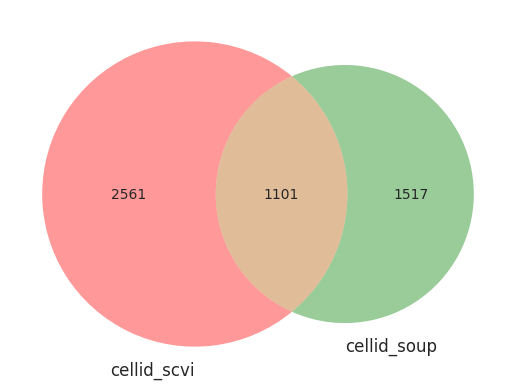

In [78]:
#Remove doublets from the first spleen dataset
adata_pl_1_raw_dob = adata_pl_1_raw[(adata_pl_1_raw.obs['status'] == 'doublet') ]
cellid_soup=adata_pl_1_raw_dob.obs.index
cellid_scvi=df_1[df_1['prediction']=='doublet'].index
common_elements = set(cellid_scvi).intersection(cellid_soup)
cellid_scvi = set(cellid_scvi)
cellid_soup = set(cellid_soup)
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
venn2([cellid_scvi, cellid_soup], ('cellid_scvi', 'cellid_soup'))
doublets= cellid_scvi.union(cellid_soup)
doublets=list(doublets)

In [79]:
doublets_in_adata_pl_1_raw= list(set(doublets).intersection(adata_pl_1_raw.obs_names))
adata_pl_1_raw.obs.loc[doublets_in_adata_pl_1_raw, 'status'] = 'doublet'
adata_pl_1_raw=adata_pl_1_raw[adata_pl_1_raw.obs['status'] == 'singlet']

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [80]:
adata_pl_1_raw.obs['assignment'].value_counts(dropna=False)

assignment
2    3610
1    3523
0    3005
Name: count, dtype: int64

In [81]:
#Rename the animals in the second spleen dataset to be 3 and 4
adata_pl_2_raw.obs['assignment']=adata_pl_2_raw.obs['assignment'].replace({'1':'3','2':'4'})

/tmp/ipykernel_2974636/572331917.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pl_2_raw.obs['assignment']=adata_pl_2_raw.obs['assignment'].replace({'1':'3','2':'4'})
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [82]:
#Integrate the two spleen datasets
sc.pp.normalize_total(adata_pl_1_raw, target_sum=1e4)
sc.pp.normalize_total(adata_pl_2_raw, target_sum=1e4)
sc.pp.log1p(adata_pl_1_raw)
sc.pp.log1p(adata_pl_2_raw)
sc.pp.highly_variable_genes(adata_pl_1_raw, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata_pl_2_raw, min_mean=0.0125, max_mean=3, min_disp=0.5)


/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

In [83]:
adata_pl_1_raw.raw=adata_pl_1_raw
adata_pl_2_raw.raw=adata_pl_2_raw

In [84]:
#Regress out the total counts and the percent mitochondrial counts
#sc.pp.regress_out(adata_pl_1_raw, ['total_counts', 'pct_counts_mt'])
#sc.pp.regress_out(adata_pl_2_raw, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_pl_1_raw, max_value=10)
sc.pp.scale(adata_pl_2_raw, max_value=10)

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


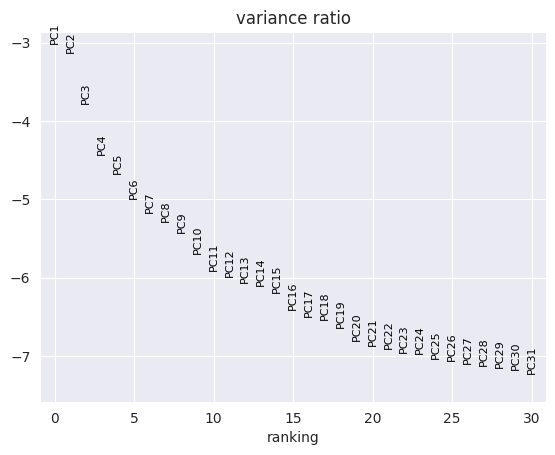

In [85]:
sc.tl.pca(adata_pl_1_raw, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_pl_1_raw, log=True)

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


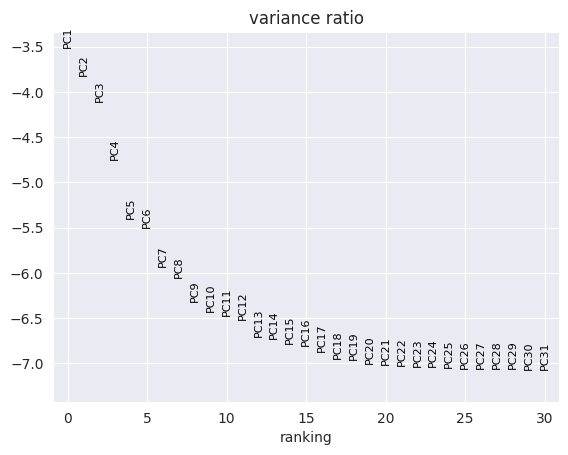

In [86]:
sc.tl.pca(adata_pl_2_raw, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_pl_2_raw, log=True)

/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


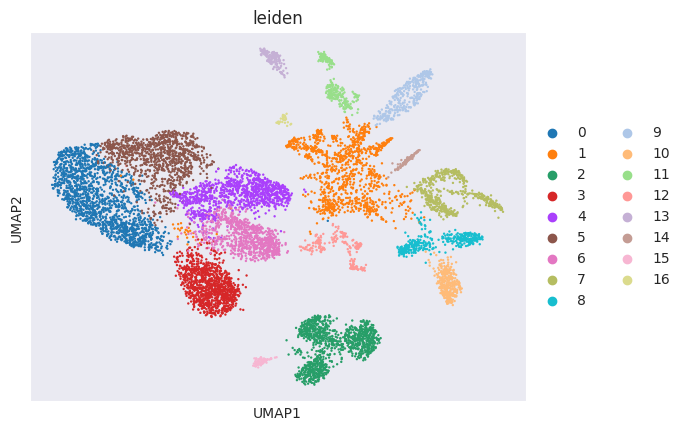

In [87]:
sc.pp.neighbors(adata_pl_1_raw, n_neighbors=30, n_pcs=40)
sc.tl.umap(adata_pl_1_raw)
sc.tl.leiden(adata_pl_1_raw,resolution=0.5)
sc.pl.umap(adata_pl_1_raw, color=['leiden'])

/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


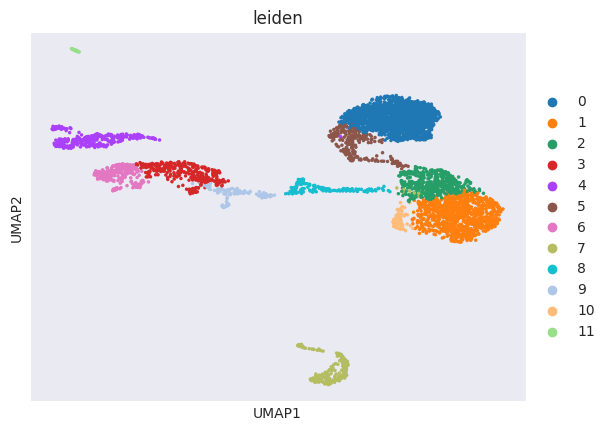

In [88]:
sc.pp.neighbors(adata_pl_2_raw, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata_pl_2_raw)
sc.tl.leiden(adata_pl_2_raw,resolution=0.5)
sc.pl.umap(adata_pl_2_raw, color=['leiden'])

In [90]:
#Integrate the two spleen datasets
adata_pl_1_raw.var_names_make_unique()
adata_pl_2_raw.var_names_make_unique()
var_names= adata_pl_1_raw.var_names.intersection(adata_pl_2_raw.var_names)
adata_pl_1_raw=adata_pl_1_raw[:,var_names]
adata_pl_2_raw=adata_pl_2_raw[:,var_names]
spleen_merged=adata_pl_1_raw.concatenate(adata_pl_2_raw)

/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/nikvaku/.local/lib/python3.9/site-packages/anndata/_core/merge.py:1015: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_indices = concat_indices.str.cat(label_col.map(str), sep=index_unique)
/home/nikvaku/.l

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
#Batch correct using Harmony
sc.external.pp.harmony_integrate(spleen_merged, 'assignment')

In [ ]:
#Re cluster the integrated spleen dataset
sc.pp.neighbors(spleen_merged, n_neighbors=30, n_pcs=30,use_rep='X_pca_harmony')
sc.tl.umap(spleen_merged)
sc.tl.leiden(spleen_merged,resolution=0.5)
sc.pl.umap(spleen_merged, color=['leiden'])

In [29]:
#Save the integrated spleen dataset
#spleen_merged.write('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/spleen_merged_processed.h5ad')

In [31]:
#Transfer the annotations to the raw spleen dataset
#leiden_mapper=dict(zip(spleen_merged.obs.index,spleen_merged.obs['leiden']))
#Read in the raw spleen dataset


In [65]:
#spleen_merged_raw=spleen_merged

In [66]:
#Leiden Mapper
#for i in leiden_mapper.keys():
#    spleen_merged_raw.obs.loc[i,'leiden']=leiden_mapper[i]

/tmp/ipykernel_2974636/2818527514.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spleen_merged_raw.obs.loc[i,'leiden']=leiden_mapper[i]


In [67]:
#Save the raw spleen dataset
#spleen_merged_raw.write('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/spleen_merged_raw.h5ad')

In [91]:
#Load in the spleen_merged dataset
spleen_merged=sc.read_h5ad('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/spleen_merged_processed.h5ad')

/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


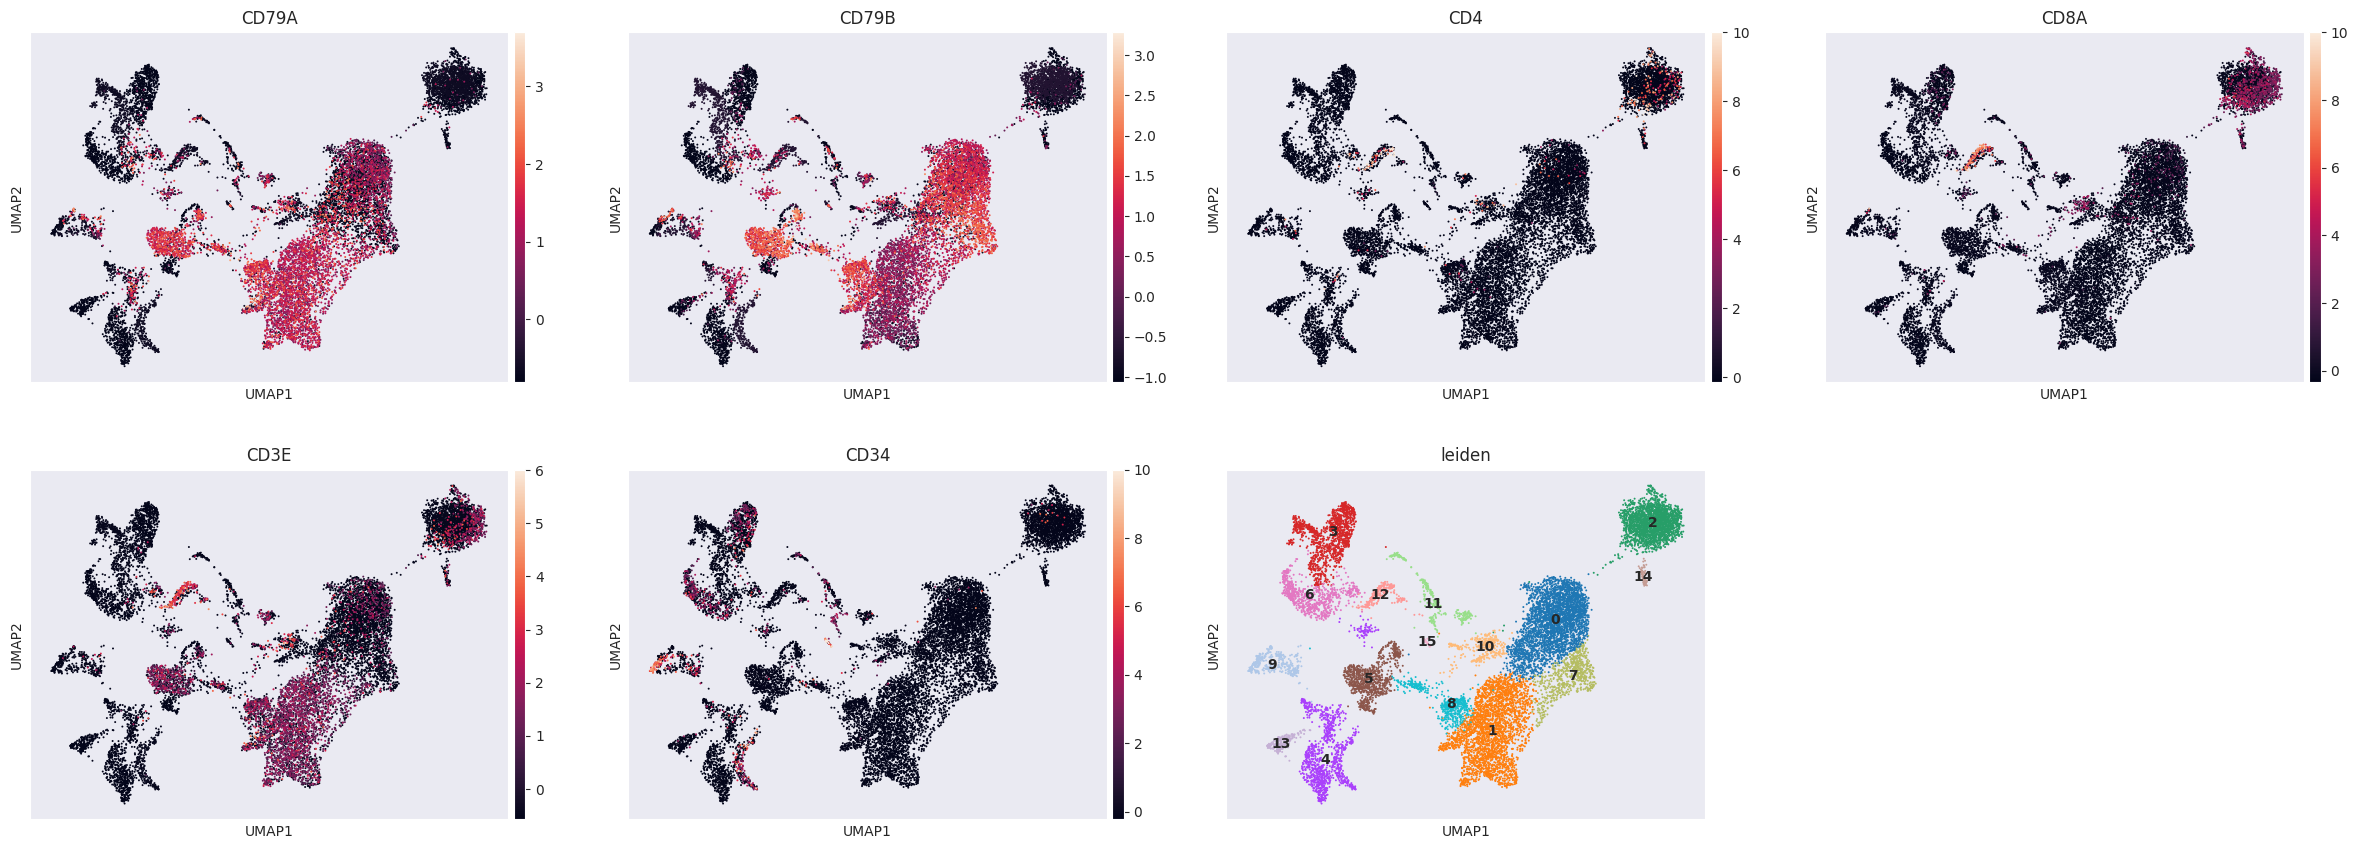

In [103]:
sc.pl.umap(spleen_merged, color=['CD79A','CD79B','CD4','CD8A','CD3E','CD34','leiden'],legend_loc='on data')

/home/nikvaku/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_group

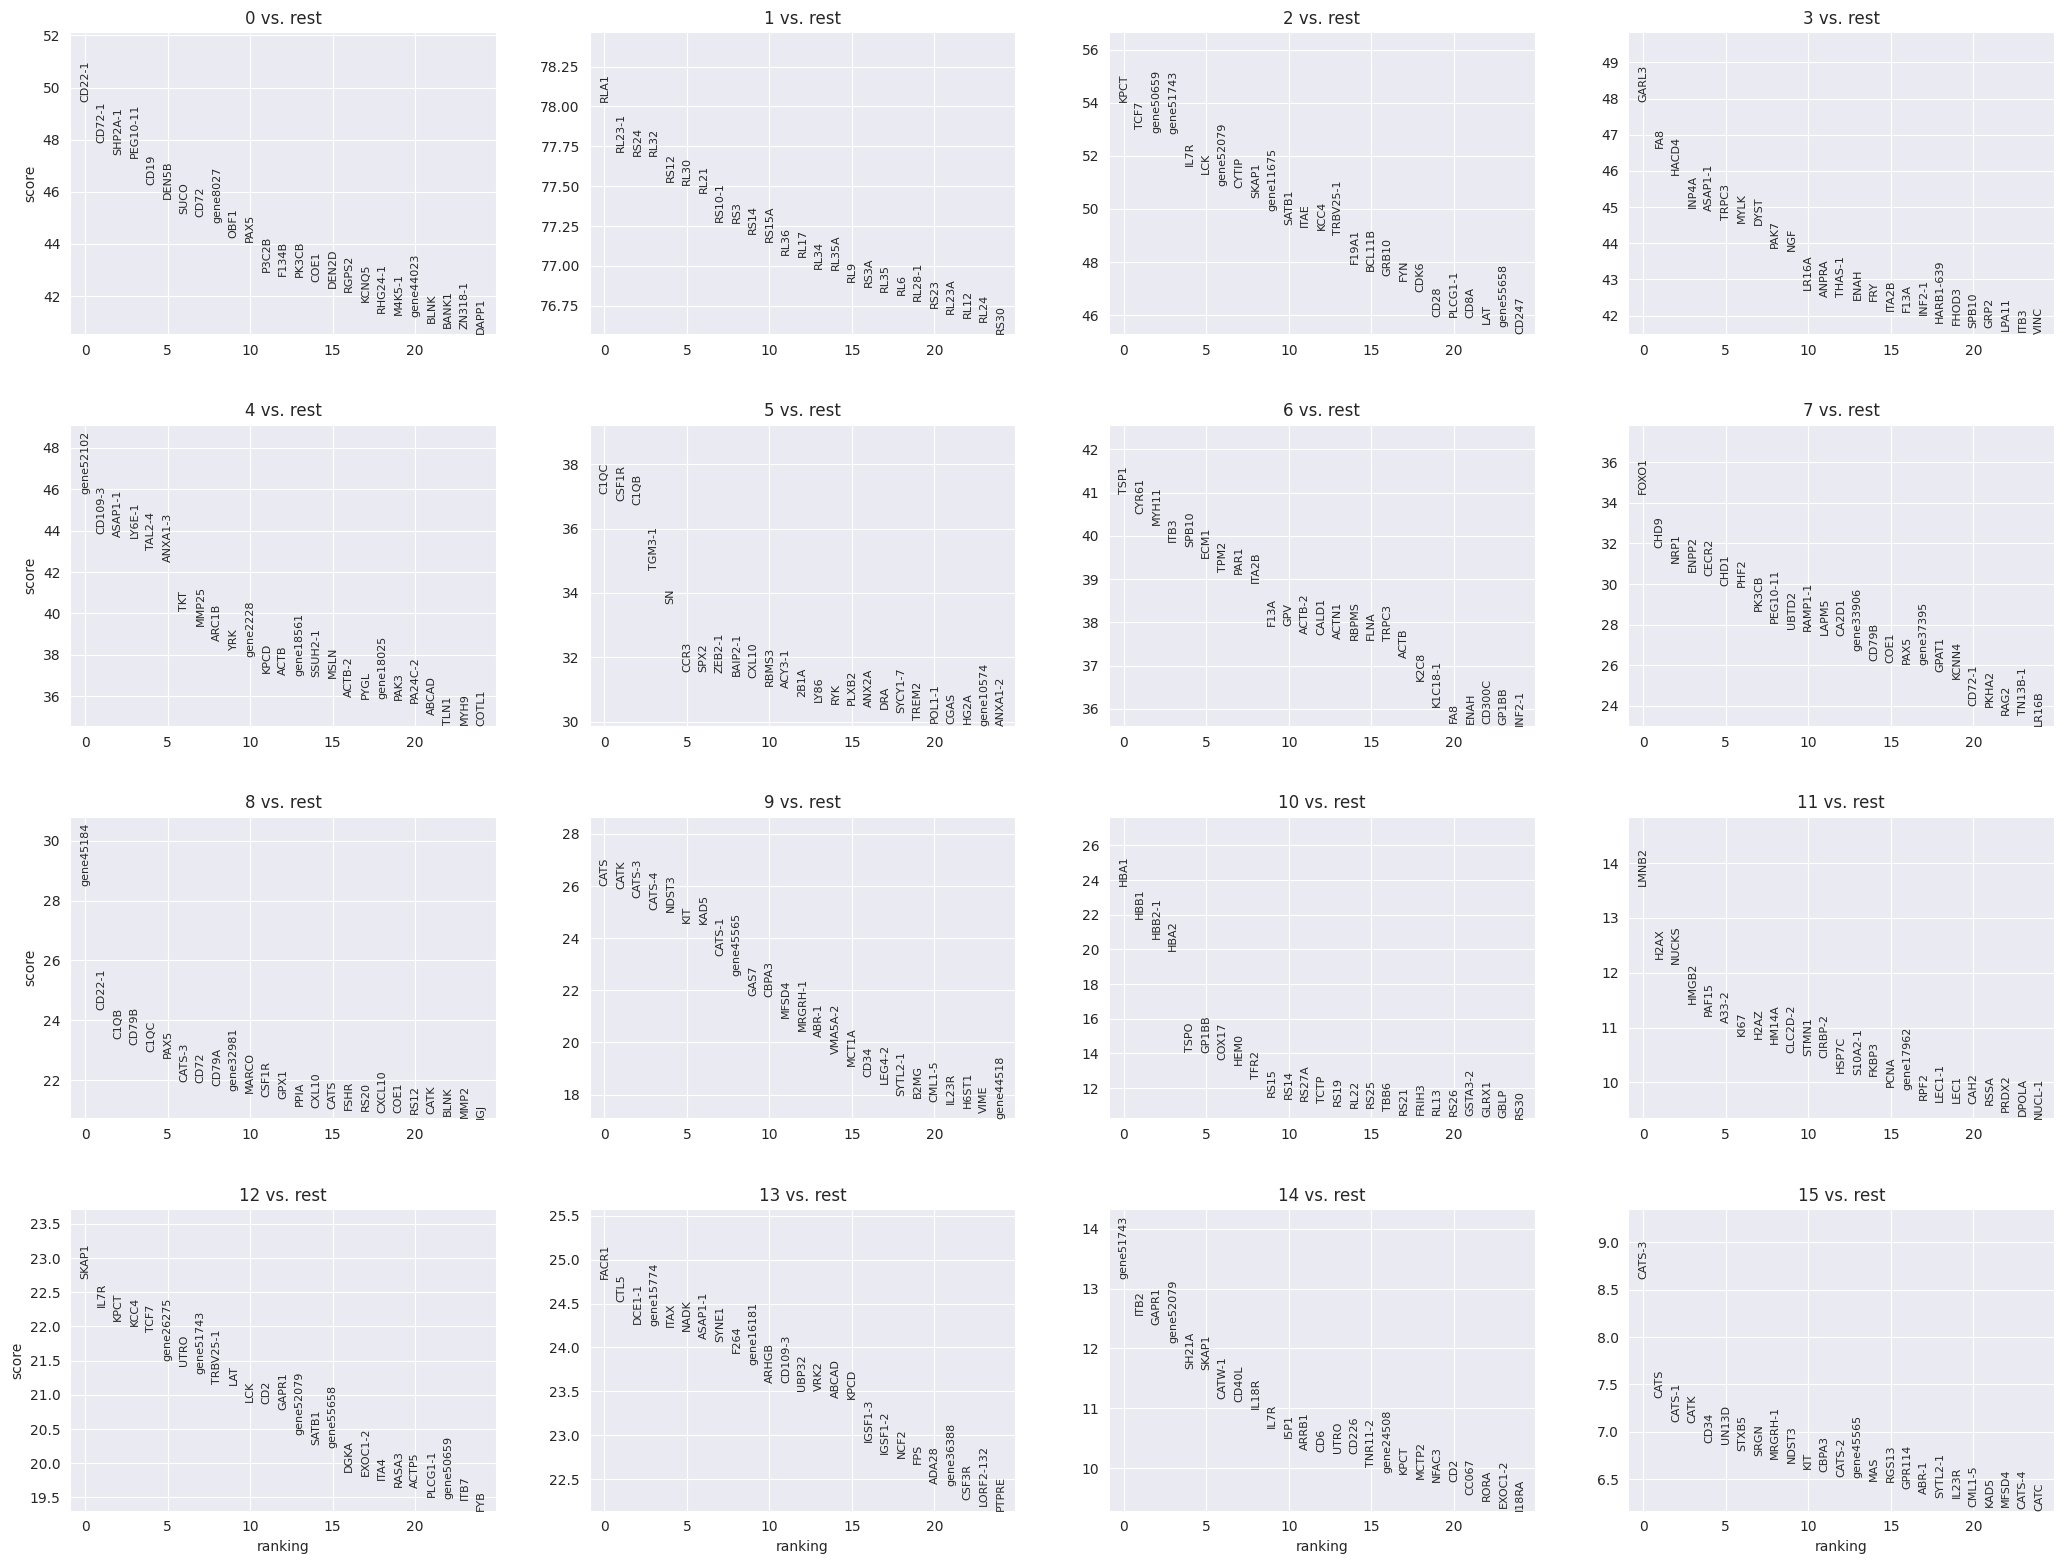

In [99]:
#DE analysis
sc.tl.rank_genes_groups(spleen_merged, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(spleen_merged, n_genes=25, sharey=False)

In [101]:
sc.get.rank_genes_groups_df(spleen_merged, group='0')

,names,scores,logfoldchanges,pvals,pvals_adj
0,CD22-1,49.445877,NaN,0.0,0.0
1,CD72-1,47.880772,NaN,0.0,0.0
2,SHP2A-1,47.411728,NaN,0.0,0.0
3,PEG10-11,47.298763,NaN,0.0,0.0
4,CD19,46.265060,NaN,0.0,0.0
...,...,...,...,...,...
34137,GMFG,-47.817585,NaN,0.0,0.0
34138,EEF1A1,-48.269642,NaN,0.0,0.0
34139,FRIHB,-48.856987,NaN,0.0,0.0
34140,ACTB,-51.070988,NaN,0.0,0.0


/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


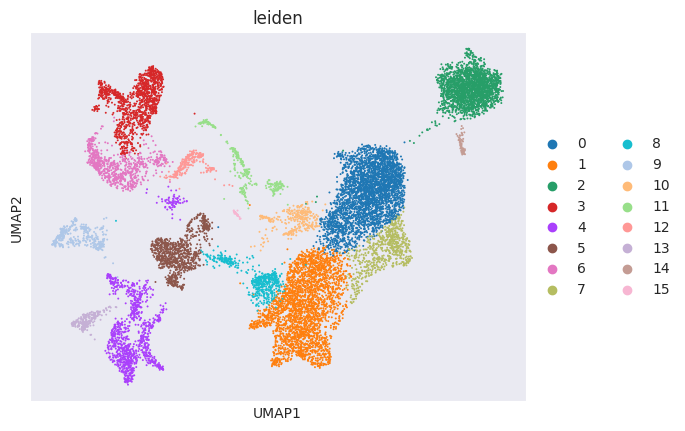

In [102]:
sc.pl.umap(spleen_merged,color='leiden')

/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


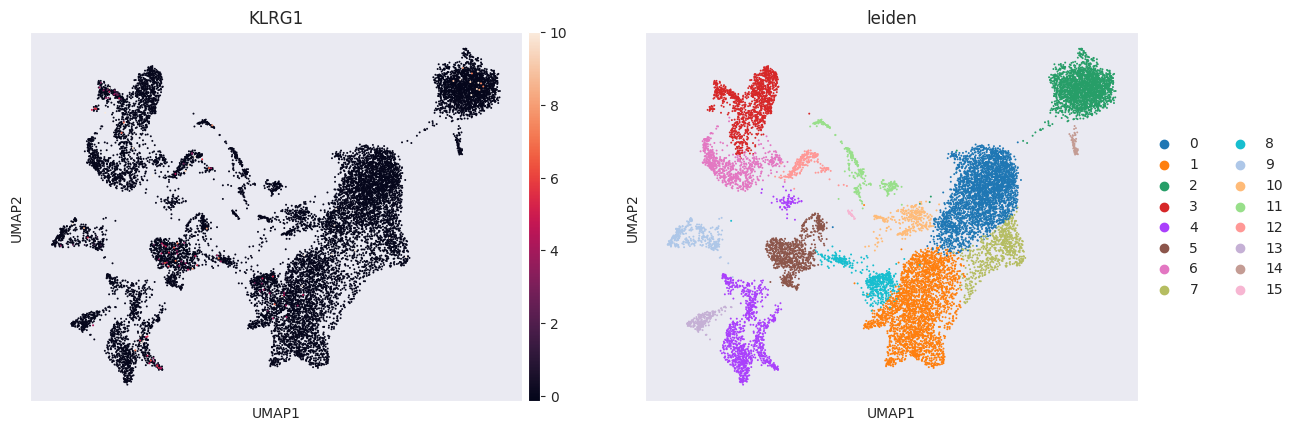

In [126]:
sc.pl.umap(spleen_merged,color=['KLRG1','leiden'])

In [124]:
for i in spleen_merged.var_names:
    if i.startswith('LNHR'):
        print(i)

/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


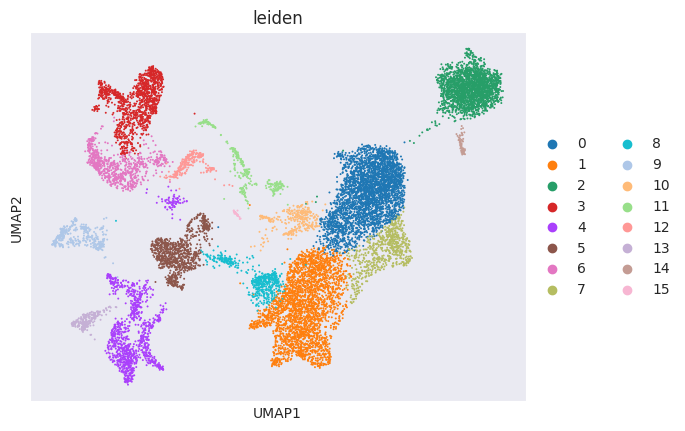

In [127]:
sc.pl.umap(spleen_merged,color=['leiden'])

/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/nikvaku/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


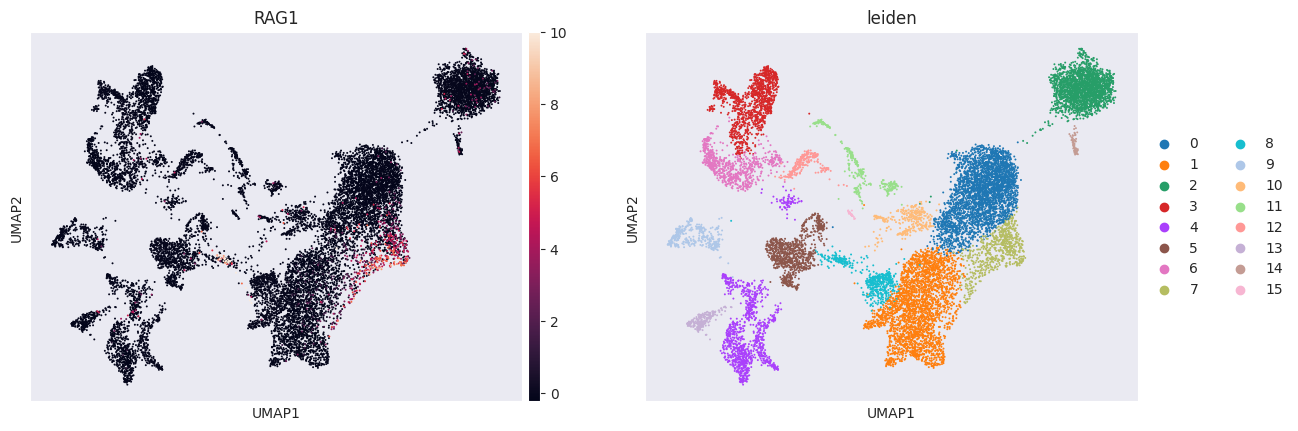

In [128]:
sc.pl.umap(spleen_merged,color=["RAG1","leiden"])